In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from theano import shared as tshared
import theano.tensor as tt
from matplotlib.colors import LogNorm
from astroML.datasets import fetch_hogg2010test
from astroML.plotting.mcmc import convert_to_stdev

In [35]:
data = fetch_hogg2010test()
df=pd.DataFrame(data)
df

,ID,x,y,sigma_x,sigma_y,rho_xy
0,1,201.0,592.0,9.0,61.0,-0.84
1,2,244.0,401.0,4.0,25.0,0.31
2,3,47.0,583.0,11.0,38.0,0.64
3,4,287.0,402.0,7.0,15.0,-0.27
4,5,203.0,495.0,5.0,21.0,-0.33
5,6,58.0,173.0,9.0,15.0,0.67
6,7,210.0,479.0,4.0,27.0,-0.02
7,8,202.0,504.0,4.0,14.0,-0.05
8,9,198.0,510.0,11.0,30.0,-0.84
9,10,158.0,416.0,7.0,16.0,-0.69


In [36]:
df_backup=df
df=df[4:]

In [37]:
#Solve the linear regression problem of Hogg Eq 5
def plot_linreg(df2):
    x,y,yerr= [df2['x'],df2['y'],df2['sigma_y']]

    A = np.vander(x, 2)
    C = np.diag(yerr * yerr)
    ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
    cov = np.linalg.inv(ATA)
    w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
    print("Least-squares estimates:")
    print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
    print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

    x0 = np.linspace(0, 300, 500)
    plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    plt.plot(x0, w[0] * x0 + w[1], "k", alpha=0.3, lw=3)

Least-squares estimates:
m = 2.240 ± 0.108
b = 34.048 ± 18.246


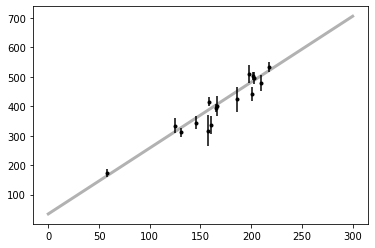

In [38]:
plot_linreg(df)

Least-squares estimates:
m = 1.077 ± 0.077
b = 213.273 ± 14.394


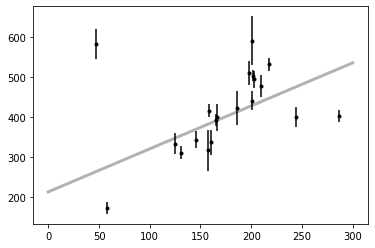

In [39]:
plot_linreg(df_backup)

In [40]:
#Solve the quadratic regression problem of Hogg Eq 5
def plot_quadreg(df):
    x,y,yerr= [df['x'],df['y'],df['sigma_y']]

    A = np.vander(x, 3)
    C = np.diag(yerr * yerr)
    ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
    cov = np.linalg.inv(ATA)
    w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
    print("Least-squares estimates:")
    print("a = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
    print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))
    print("c = {0:.3f} ± {1:.3f}".format(w[2], np.sqrt(cov[2, 2])))
    
    x0 = np.linspace(0, 300, 500)
    plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    plt.plot(x0, w[0] * x0**2 + w[1] * x0 + w[2], "k", alpha=0.3, lw=3)

Least-squares estimates:
a = 0.002 ± 0.002
b = 1.596 ± 0.580
c = 72.895 ± 38.912


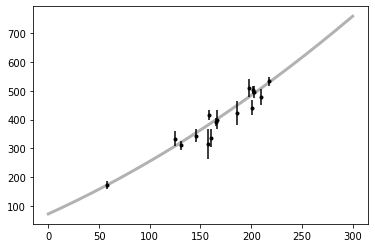

In [41]:
plot_quadreg(df)

In [42]:
#Section 3. Adapted from AstroML documentation
np.random.seed(0)

# ------------------------------------------------------------
# Get data: this includes outliers. We need to convert them to Theano variables

xi = tshared(data['x'])
yi = tshared(data['y'])
dyi = tshared(data['sigma_y'])
size = len(data)

In [43]:
# ----------------------------------------------------------------------
# Define basic linear model

def model(xi, theta, intercept):
    slope = np.tan(theta)
    return slope * xi + intercept

# ----------------------------------------------------------------------
# This is the mixture model given in equation 17 in Hogg et al
def mixture_likelihood(yi, xi):

    sigmab = tt.exp(log_sigmab)
    mu = model(xi, theta, inter)

    Vi = dyi ** 2
    Vb = sigmab ** 2

    root2pi = np.sqrt(2 * np.pi)

    L_in = (1. / root2pi / dyi * np.exp(-0.5 * (yi - mu) ** 2 / Vi))

    L_out = (1. / root2pi / np.sqrt(Vi + Vb)
             * np.exp(-0.5 * (yi - Yb) ** 2 / (Vi + Vb)))

    return tt.sum(tt.log((1 - Pb) * L_in + Pb * L_out))


with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -200, 400)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2, testval=np.pi / 4)

    y_mixture = pm.DensityDist('mixturenormal', logp=mixture_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace1 = pm.sample(draws=5000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, inter, log_sigmab, Yb, Pb]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:14<00:00, 1619.37draws/s]
The acceptance probability does not match the target. It is 0.9241545678446612, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826326560446394, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [44]:
H2D, bins1, bins2 = np.histogram2d(np.tan(trace1['theta']),trace1['inter'], bins=50)

In [45]:
sorted_hist=np.sort(H2D,axis=None)
top10=sorted_hist[-10:]
x0 = np.linspace(0, 300, 500)
w = np.where(H2D == H2D.max())
bins1[w[0][0]]

2.227578584601849

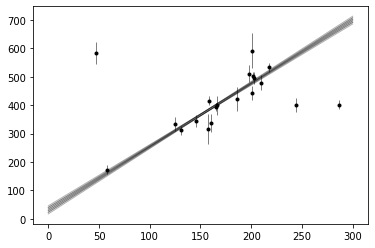

In [46]:
#Part 1 of exercise 6
w = np.where(H2D == H2D.max())

for i in range(0,10):
    w=np.where(H2D==top10[i])
# choose the maximum posterior slope and intercept
    slope_best = bins1[w[0][0]]
    intercept_best = bins2[w[1][0]]

    plt.plot(x0, slope_best * x0 + intercept_best, "k", alpha=0.3, lw=1)
#plot the data
plt.errorbar(data['x'], data['y'], data['sigma_y'], fmt='.k', ecolor='gray', lw=1);

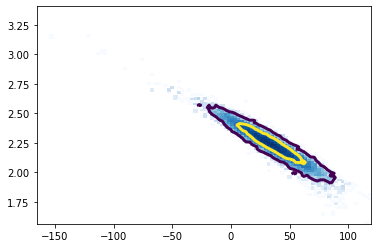

In [47]:
#part 2 of exercise 6
counts,xbins,ybins,image=plt.hist2d(trace1['inter'],np.tan(trace1['theta']),bins=100,norm=LogNorm(),cmap='Blues');
plt.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
    linewidths=3,levels=[5, 80])

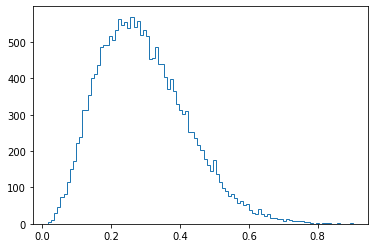

In [48]:
#part 1 of exercise 7
plt.hist(trace1['Pb'], bins=100,histtype=u'step');

In [24]:
data2=fetch_hogg2010test()
data2['sigma_y']=data2['sigma_y']/2.0

In [28]:
xi = tshared(data2['x'])
yi = tshared(data2['y'])
dyi = tshared(data2['sigma_y'])
size = len(data2)

with pm.Model():
    # uniform prior on Pb, the fraction of bad points
    Pb = pm.Uniform('Pb', 0, 1.0, testval=0.1)

    # uniform prior on Yb, the centroid of the outlier distribution
    Yb = pm.Uniform('Yb', -10000, 10000, testval=0)

    # uniform prior on log(sigmab), the spread of the outlier distribution
    log_sigmab = pm.Uniform('log_sigmab', -10, 10, testval=5)

    inter = pm.Uniform('inter', -200, 400)
    theta = pm.Uniform('theta', -np.pi / 2, np.pi / 2, testval=np.pi / 4)

    y_mixture = pm.DensityDist('mixturenormal', logp=mixture_likelihood,
                               observed={'yi': yi, 'xi': xi})

    trace1 = pm.sample(draws=5000, init='nuts',tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using nuts...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, inter, log_sigmab, Yb, Pb]
Sampling 4 chains, 0 divergences: 100%|██████████| 1200000/1200000 [27:14<00:00, 734.16draws/s] 
The acceptance probability does not match the target. It is 0.1326137775878474, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9041887454582075, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9719592632670577, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9606555967070265, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, inter, log_sigmab,

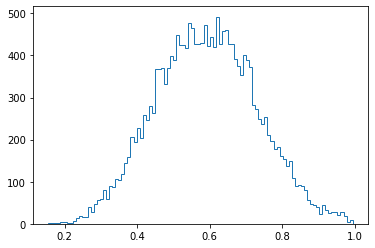

In [29]:
#part 2 of exercise 7
plt.hist(trace1['Pb'], bins=100,histtype=u'step');

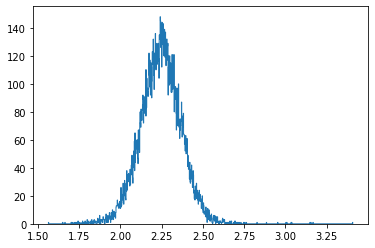

In [49]:
#Exercise 8: The distribution of sigma_m
plt.hist(np.tan(trace1['theta']), bins=1000,histtype=u'step');

Least-squares estimates:
m = 1.077 ± 0.077
b = 213.273 ± 14.394


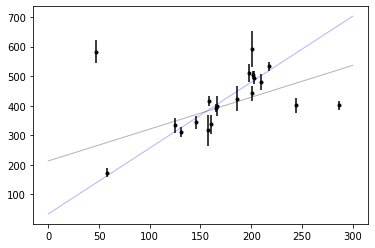

In [50]:
#checking best fit of matrix method vs. outlier pruning
x,y,yerr= [data['x'],data['y'],data['sigma_y']]

A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))
x0 = np.linspace(0, 300, 500)
plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, w[0] * x0 + w[1], "k", alpha=0.3, lw=1)

w=np.where(H2D==top10[i])
# choose the maximum posterior slope and intercept
slope_best = bins1[w[0][0]]
intercept_best = bins2[w[1][0]]
plt.plot(x0, slope_best * x0 + intercept_best, "k", alpha=0.3, lw=1, color='b');

In [51]:
# draw a sample from population
slopes=np.tan(trace1['theta'])
sample = np.random.choice(slopes, size=30)
sample

array([2.22022395, 2.25457362, 2.29277401, 2.14660243, 2.20638579,
       2.36757095, 2.03890332, 2.35769855, 2.12359512, 2.37359079,
       2.23577322, 2.32442241, 2.16728969, 2.26406253, 2.10886251,
       2.09456631, 2.37148197, 2.00755932, 2.10747171, 2.39945439,
       2.21746264, 2.24901356, 2.22815393, 1.97511143, 2.24364813,
       2.29638399, 2.27712229, 2.24065041, 2.31028153, 2.14874074])

In [52]:
import dill
dill.dump_session('notebook_env.db')